In [163]:
import warnings
warnings.filterwarnings(action='ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bot.config.settings import Settings
from bot.core.encoder import TextEncoder
from bot.data.dataset import DatasetManager
from bot.model.utils import read_best_params
from sklearn.model_selection import (StratifiedKFold, cross_val_score, cross_val_predict, train_test_split)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [164]:
encoder = TextEncoder(Settings.MODEL_CLS)
root = Path().cwd().parent
dm = DatasetManager(path=root / "data/data.csv")
X, y = encoder.encode(dm.get_X()), np.where(dm.get_y() == 0, -1, 1)
X_tain, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=Settings.RNG_INT, shuffle=True, stratify=y)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=Settings.RNG_INT)

In [165]:
best_params = read_best_params(root / "bot/model/optunalogs/linear_svc_1743317634.json")
clf = LinearSVC(**best_params, max_iter=10_000, random_state=Settings.RNG_INT)

In [166]:
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')

print(f"f1: {f1_scores.mean()} +/- {f1_scores.std()}")
print(f"recall: {recall_scores.mean()} +/- {recall_scores.std()}")
print(f"precision: {precision_scores.mean()} +/- {precision_scores.std()}")

f1: 0.9785984848484848 +/- 0.019792346298320815
recall: 0.9764705882352942 +/- 0.03901911518065177
precision: 0.9823529411764707 +/- 0.026956327617387303


In [167]:
def threshold_cross_validation(estimator, X, y, thresholds, cv=5):
    y_scores = cross_val_predict(estimator, X, y, cv=cv, method="predict_proba")[:, 1]
    results = []
    for thresh in thresholds:
        y_pred = np.where((y_scores >= thresh).astype(int) == 0, -1, 1)
        precision = precision_score(y, y_pred, zero_division=0)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        results.append({
            "Threshold": thresh,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })
    return pd.DataFrame(results)

In [168]:
results_df = threshold_cross_validation(
    CalibratedClassifierCV(clf, method="sigmoid", cv=cv, ensemble=True, n_jobs=5), 
    X, y,
    thresholds=np.linspace(0.4, 0.95, 12),
    cv=cv
)

In [169]:
results_df

,Threshold,Precision,Recall,F1
0,0.40,0.976048,0.976048,0.976048
1,0.45,0.981928,0.976048,0.978979
2,0.50,0.981707,0.964072,0.972810
3,0.55,0.981481,0.952096,0.966565
4,0.60,0.987421,0.940120,0.963190
5,0.65,0.987013,0.910180,0.947040
6,0.70,0.986842,0.898204,0.940439
7,0.75,0.993289,0.886228,0.936709
8,0.80,0.992857,0.832335,0.905537
9,0.85,0.992063,0.748503,0.853242


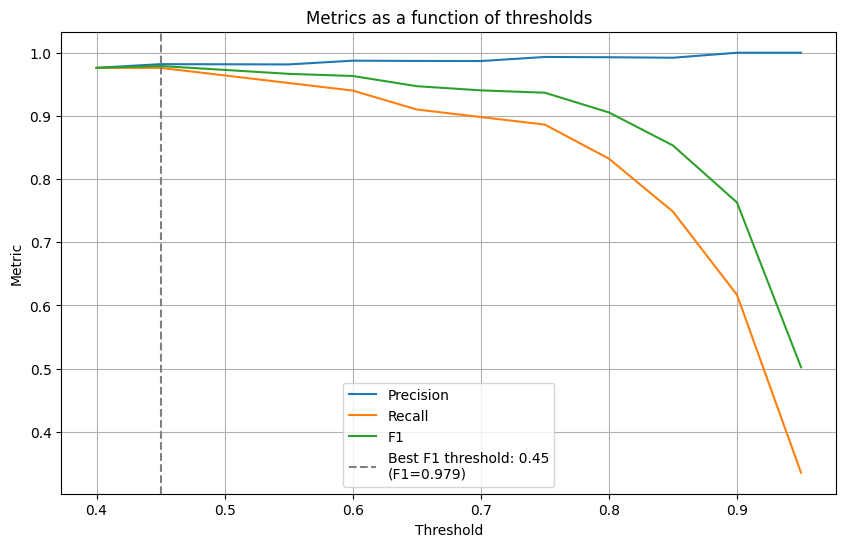

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1"], label="F1")
    
best_idx = results_df["F1"].idxmax()
best_thresh = results_df.loc[best_idx, "Threshold"]
best_f1 = results_df.loc[best_idx, "F1"]
    
plt.axvline(x=best_thresh, color="gray", linestyle="--", label=f"Best F1 threshold: {best_thresh:.2f}\n(F1={best_f1:.3f})")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("Metrics as a function of thresholds")
plt.legend()
plt.grid(True)
plt.show()